In [49]:
import rasterio
import geopandas as gpd
# import dask.array as da
# from dask_rasterio import read_raster, write_raster
import os
import fnmatch

input_dir=r"Z:\LWI_StageIV\test"
crop_shp = gpd.read_file(r"Z:\GIS\StageIv Boundary.shp")
background_shp = gpd.read_file(r"Z:\GIS\Louisiana.shp")
img_dir = os.path.join(input_dir, 'img')
projected_dir = os.path.join(input_dir, 'projected')
cropped_dir = os.path.join(input_dir, 'cropped')

merge_dir=[]
for filename in fnmatch.filter(os.listdir(input_dir),'*.01h'): 
    merge_dir.append((os.path.join(input_dir, filename)))

merge_dir.sort()

In [51]:
# import xarray as xr
import numpy as np
from rasterio.warp import calculate_default_transform, reproject, Resampling
import earthpy.spatial as es
# raster = merge_dir[20]
dst_crs = 'EPSG:4326'
arrayList = []
for raster in merge_dir:
    # print(f'adding {raster} to dask array list: map2array')
    src = rasterio.open(raster)
    transform, width, height = calculate_default_transform(
        src.crs, dst_crs, src.width, src.height, *src.bounds)
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': dst_crs,
        'transform': transform,
        'width': width,
        'height': height
    })
    projected_raster = projected_dir + '\\' + raster.split("\\")[-1]
    with rasterio.open(projected_raster, 'w', **kwargs) as dst:
        for i in range(1, src.count + 1):
            reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                resampling=Resampling.nearest)
    src_projected = rasterio.open(projected_raster)
    crop_raster, crop_meta = es.crop_image(src_projected, crop_shp)
    # array = src.read(1)
    array = crop_raster
    array[array==0] = np.nan    
    array[array==9999] = np.nan
    arrayList.append(array)
    src.close()
    src_projected.close()
    cropped_raster_file = cropped_dir + '\\' + raster.split("\\")[-1]
    with rasterio.open(cropped_raster_file, 'w', **kwargs) as dest:
        dest.write(array.squeeze().astype(rasterio.uint8), 1)

C:\Tools\Anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  from ipykernel import kernelapp as app


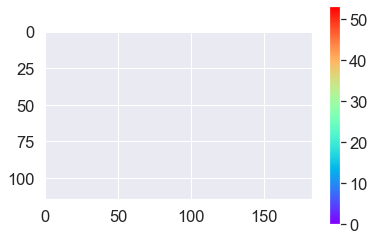

In [12]:
from rasterio.plot import show
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")
sns.set(font_scale=1.5)



plt.imshow(  array.squeeze(), 
                cmap='rainbow', 
                vmin=0,
                vmax=53)
# pyplot.show()
plt.colorbar()

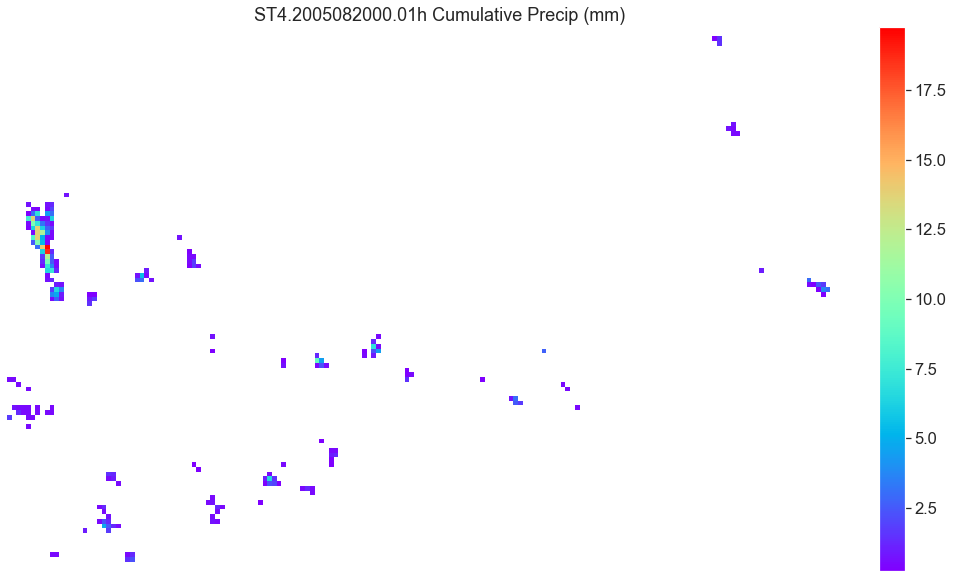

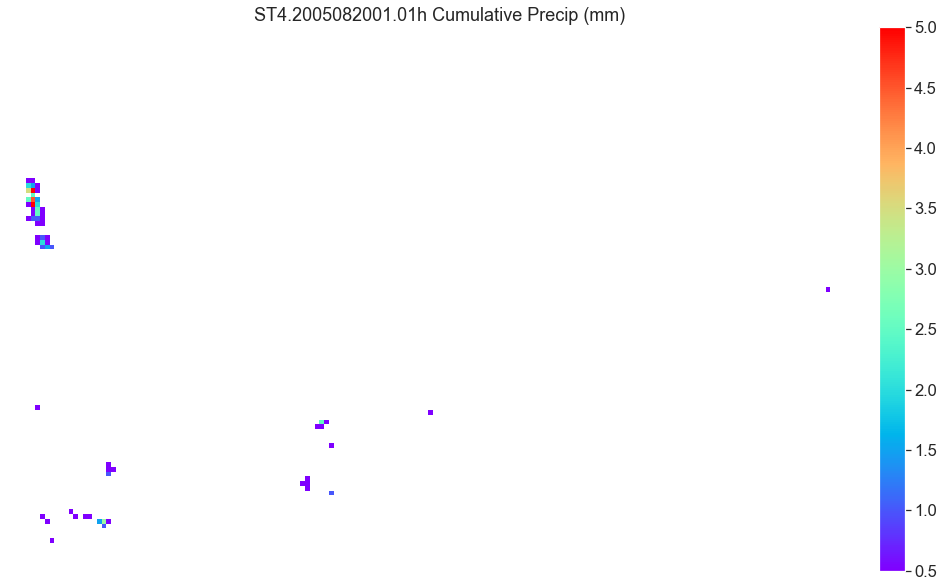

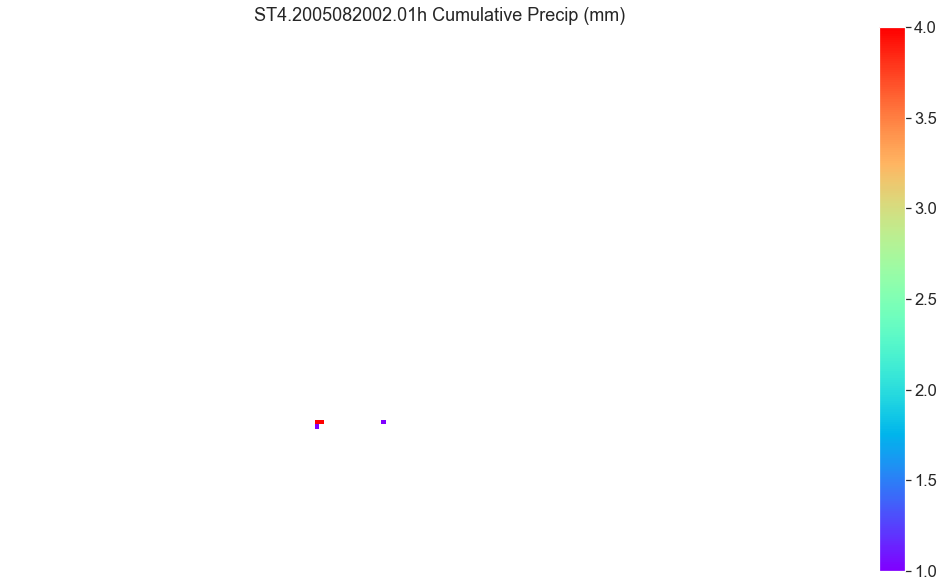

In [24]:
import earthpy.plot as ep
for i, array in enumerate(arrayList):
    # plt.imshow(  array.squeeze(), 
    #             cmap='rainbow', 
    #             vmin=0,
    #             vmax=53)
    # plt.colorbar()
    
    fig, ax = plt.subplots(figsize = (20, 10))

    im = ax.imshow(array.squeeze(), cmap='rainbow')
# plt.plot(cropped_raster[1:])
# world.geometry.boundary.plot(ax=ax, color=None, alpha = 1, edgecolor='black', linewidth = 1.0)

    ep.colorbar(im)
    title = merge_dir[i].split('\\')[-1]
    ax.set(title=f"{title} Cumulative Precip (mm)")
    ax.set_axis_off()
    img_filename = img_dir + f'\\{title}.png'
    plt.savefig((img_filename))
    # plt.close()
    plt 


<AxesSubplot:title={'center':'ST4.2005082002.01h Cumulative Precip (mm)'}>

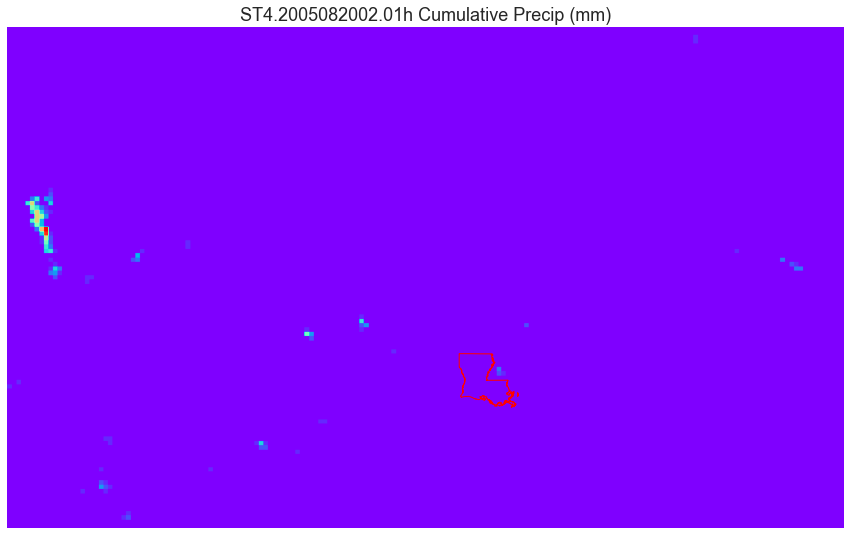

In [55]:
cropped_raster = rasterio.open(r"Z:\LWI_StageIV\test\cropped\ST4.2005082000.01h")
fig, ax = plt.subplots(figsize=(15, 10))

# src_projected[src_projected==0] = np.nan    
# src_projected[src_projected==9999] = np.nan
rasterio.plot.show(cropped_raster, transform=src_projected.transform, ax=ax, cmap='rainbow')
shapefile = gpd.read_file(r"Z:\GIS\StageIv Boundary.shp", ax=ax)
ax.set(title=f"{title} Cumulative Precip (mm)")
ax.set_axis_off()
# colorbar = fig.colorbar(r, ax=ax)
background_shp.plot(ax=ax, facecolor='none', edgecolor='red')

In [40]:
array.crs

AttributeError: 'numpy.ndarray' object has no attribute 'crs'

In [39]:
src_projected.crs

CRS.from_epsg(4326)

In [44]:
src_projected.nodata

9999.0

In [ ]:
import imageio

imgList=[]
for img_file in fnmatch.filter(os.listdir(img_dir),'*.png'): 
    imgList.append((os.path.join(img_dir, img_file)))

imgList.sort()
images = []
for img in imgList:
    images.append(imageio.imread(img))
imageio.mimsave('movie.gif', images)